# Making the CliffWalking Environment

The CliffWalking environment as described in Sutton and Barto's book is a (4,12) grid environment where the bottom row consists of the
1. The starting point (lower left corner)
2. The goal (lower right corner)
3. The cliff (all 1st row squares except start and goal)

The intuition is for the agent to learn to avoid the cliff while walking towards the goal. 
___
### Rules
- Reaching the goal ends the episode.
- If the agent steps on the cliff, the episode ends with a -100 reward and the env is reset (agent goes back to start).
- Any other square the agent steps into nets only a -1 reward.
- Therefore, the highest reward the agent can get is by skirting around the cliff directly towards the goal in 13 actions. Highest possible reward per episode is -13. 

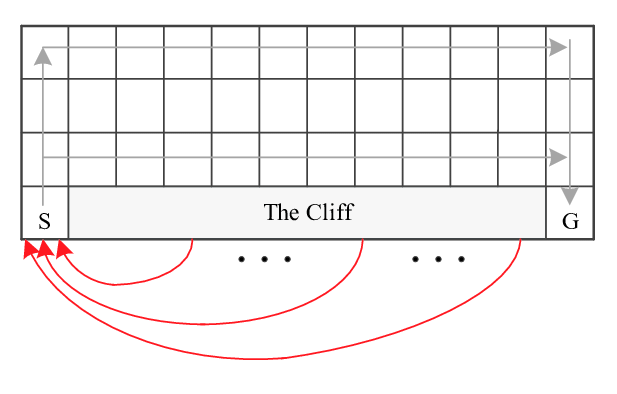

In [ ]:
import sys
import os
if "./" not in sys.path:
  sys.path.append("./") 

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import itertools
from collections import defaultdict
from lib import plotting
from tqdm import tqdm
from copy import deepcopy

matplotlib.style.use('ggplot')

In [ ]:
from gym import error, spaces, utils

## Design (Skip to the end for executable code)

Since the environment must be modular with the OpenAI gym framework, it inherits the gym.Env class. 

I wanted to make the gridworld flexible, with dynamic rows and columns. We initialize this and assert that a cliff can be formed with the given grid size, and we also set the start and the goal at [0,0] and [0,cols-1] respectively.

```python
class CliffWalkingEnv(gym.Env):

    def __init__(self, rows=4, cols=12):

        assert(rows > 1), 'Unsolvable Cliff. Argument rows must be > 1'
        assert(cols > 2), 'No Cliff. Argument cols must be > 2'

        self.grid_size = (rows,cols)
        self.start = [0,0]
        self.goal = [0, cols-1]

        # initial position
        self.position = deepcopy(self.start)
```

the action space must be set to 4 discrete actions (up, down, left, right) while the observation space is row*columns amount of states.

```python
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(np.prod(self.grid_size))
```

Everytime the episode ends, the environment must be reset. The reset method simply changes the agent's position back to starting point.

```python
    def reset(self):
        '''
        Resets position of agent to (0,0)
        '''

        self.position = deepcopy(self.start)
```

To obtain observations/states from the environment, we get the current position of the agent and return it with two methods: as an `int` representative of the state and as a onehot-vector for use in logistic regression. 

```python
    def get_state(self):
        '''
        Returns the state # based on the agent's position.
        E.g. given a (4,12) cliff with (0,0) origin and an agent at (1,3), 
        state # would be:

        state = (1 * 12) + 3 = 16
        '''

        position = self.position
        cols = self.grid_size[1]

        return (position[0] * cols) + position[1]

    def get_state_onehot(self):
        '''
        Returns the state, but in one-hot vector form.
        '''

        n_states = np.prod(self.grid_size)

        s = self.get_state()
        s_onehot = [0.0] * np.prod(self.grid_size)
        s_onehot[s] = 1.0

        return s_onehot
```

A step on the environment is when the agent performs an action which affects the current state of the environment, moving it the next state, while being rewarded for the action. 

In cliffwalking, there are only 4 actions (up,left,down,right) but the actions must also be limited when the model is at the sides of the grid world (the agent cannot go up when it is already at the top row). 

```python
    def step(self, action):
        '''
        One timestep of the agent performing an action. Actions should be 
        up, down, left, right (integers 0 to 3) limited by the grid. 
        '''

        assert(0 <= action <= 3), "Invalid action. Action should be within [0,3]"

        position = deepcopy(self.position)
        rows, cols = self.grid_size
        
        if action == 0: #up
            position[0] = min(position[0]+1, rows-1)
        elif action == 1: #down
            position[0] = max(position[0]-1, 0)
        elif action == 2: #left
            position[1] = max(position[1]-1, 0)
        elif action == 3: #right
            position[1] = min(position[1]+1, cols-1)

        self.position = position
        new_state = self.get_state()
```

Finally, the reward function as described is: -1 for each action that doesn't go into the cliff, and -100 when going into a cliff. Episode ends when agent enters a cliff square or the goal square (`done` flag is returned as `True`)

```python
        # Cliff states are from [1, cols-2], recall 0 is start and cols-1 is goal
        if 0 < new_state < cols-1:
            reward = -100
        else:
            reward = -1

        # Did the agent fall off the cliff or reach the goal? 
        done = (0 < new_state <= cols-1)


        return new_state, reward, done, {}   
```

In [ ]:
class CliffWalkingEnv(gym.Env):

    def __init__(self, rows=4, cols=12):

        assert(rows > 1), 'Unsolvable Cliff. Argument rows must be > 1'
        assert(cols > 2), 'No Cliff. Argument cols must be > 2'

        self.grid_size = (rows,cols)
        self.start = [0,0]
        self.goal = [0, cols-1]

        # initial position
        self.position = deepcopy(self.start)

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(np.prod(self.grid_size))

    def get_state(self):
        '''
        Returns the state # based on the agent's position.
        E.g. given a (4,12) cliff with (0,0) origin and an agent at (1,3), 
        state # would be:

        state = (1 * 12) + 3 = 16
        '''

        position = self.position
        cols = self.grid_size[1]

        return (position[0] * cols) + position[1]

    def get_state_onehot(self):
        '''
        Returns the state, but in one-hot vector form.
        '''

        n_states = np.prod(self.grid_size)

        s = self.get_state()
        s_onehot = [0.0] * np.prod(self.grid_size)
        s_onehot[s] = 1.0

        return s_onehot

    def reset(self):
        '''
        Resets position of agent to (0,0)
        '''

        self.position = deepcopy(self.start)


    def step(self, action):
        '''
        One timestep of the agent performing an action. Actions should be 
        up, down, left, right (integers 0 to 3) limited by the grid. 
        '''

        assert(0 <= action <= 3), "Invalid action. Action should be within [0,3]"

        position = deepcopy(self.position)
        rows, cols = self.grid_size
        
        if action == 0: #up
            position[0] = min(position[0]+1, rows-1)
        elif action == 1: #down
            position[0] = max(position[0]-1, 0)
        elif action == 2: #left
            position[1] = max(position[1]-1, 0)
        elif action == 3: #right
            position[1] = min(position[1]+1, cols-1)

        self.position = position
        new_state = self.get_state()

        # Cliff states are from [1, cols-2], recall 0 is start and cols-1 is goal
        if 0 < new_state < cols-1:
            reward = -100
        else:
            reward = -1

        # Did the agent fall off the cliff or reach the goal? 
        done = (0 < new_state <= cols-1)


        return new_state, reward, done, {}        